<pre>
1. Download the data from <a href='https://drive.google.com/file/d/15dCNcmKskcFVjs7R0ElQkR61Ex53uJpM/view?usp=sharing'>here</a>

2. Code the model to classify data like below image

<img src='https://i.imgur.com/33ptOFy.png'>

3. Write your own callback function, that has to print the micro F1 score and AUC score after each epoch.

4. Save your model at every epoch if your validation accuracy is improved from previous epoch. 

5. you have to decay learning based on below conditions 
        Cond1. If your validation accuracy at that epoch is less than previous epoch accuracy, you have to decrese the
               learning rate by 10%. 
        Cond2. For every 3rd epoch, decay your learning rate by 5%.
        
6. If you are getting any NaN values(either weigths or loss) while training, you have to terminate your training. 

7. You have to stop the training if your validation accuracy is not increased in last 2 epochs.

8. Use tensorboard for every model and analyse your gradients. (you need to upload the screenshots for each model for evaluation)

9. use cross entropy as loss function

10. Try the architecture params as given below. 
</pre>

<pre>
<b>Model-1</b>
<pre>
1. Use tanh as an activation for every layer except output layer.
2. use SGD with momentum as optimizer.
3. use RandomUniform(0,1) as initilizer.
3. Analyze your output and training process. 
</pre>
</pre>
<pre>
<b>Model-2</b>
<pre>
1. Use relu as an activation for every layer except output layer.
2. use SGD with momentum as optimizer.
3. use RandomUniform(0,1) as initilizer.
3. Analyze your output and training process. 
</pre>
</pre>
<pre>
<b>Model-3</b>
<pre>
1. Use relu as an activation for every layer except output layer.
2. use SGD with momentum as optimizer.
3. use he_uniform() as initilizer.
3. Analyze your output and training process. 
</pre>
</pre>
<pre>
<b>Model-4</b>
<pre>
1. Try with any values to get better accuracy/f1 score.  
</pre>
</pre>

## 1. Loading dataset and Visualize 

In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd

In [3]:
data = pd.read_csv("data.csv")

In [4]:
data.head()

,f1,f2,label
0,0.450564,1.074305,0.0
1,0.085632,0.967682,0.0
2,0.117326,0.971521,1.0
3,0.982179,-0.380408,0.0
4,-0.720352,0.955850,0.0


In [5]:
data.describe()

,f1,f2,label
count,20000.000000,20000.000000,20000.000000
mean,0.000630,-0.000745,0.500000
std,0.671165,0.674704,0.500013
min,-1.649781,-1.600645,0.000000
25%,-0.589878,-0.596424,0.000000
50%,0.001795,-0.003113,0.500000
75%,0.586631,0.597803,1.000000
max,1.629722,1.584291,1.000000


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

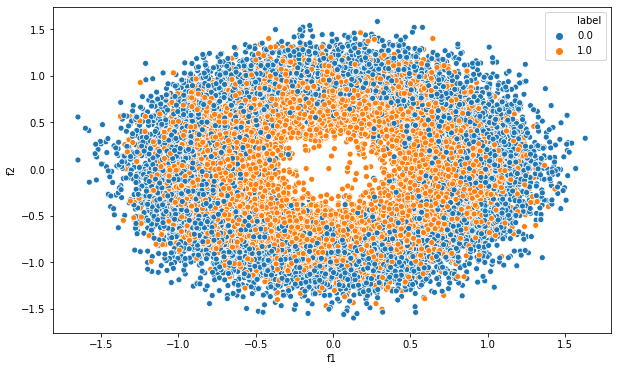

In [7]:
plt.figure(figsize=(10,6))
sns.scatterplot('f1', 'f2', hue='label', data=data)

**Observations**
1. data is in circular shape
2. positive datapoints residing towards inside of the circle
3. Negative datapoints residing towards outside of the circle. 
4. There is a lot of overlap between the dataset classes.
5. Linear Algorithms can't classify it better
6. Even traditional ML Algorithms will survive to classify it better.
7. DL Algorithms is the best option for this

**reshaping the data**

In [8]:
X, Y = data[['f1','f2']], data['label']
X.shape, Y.shape

((20000, 2), (20000,))

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

In [11]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((16000, 2), (16000,), (4000, 2), (4000,))

## 2. Code the model to classify data like below image
<img src='https://i.imgur.com/33ptOFy.png'>

In [12]:
def create_model():
    return tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(2,)),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(84, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

In [13]:
model = create_model()

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               1536      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 84)                10836     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2720      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 179,349
Trainable params: 179,349
Non-trainable params: 0
__________________________________________________

## 3. Write you own Callback function
**that has to print the micro F1 score and AUC score after each epoch.**

In [15]:
from sklearn.metrics import f1_score, roc_auc_score
class GetScore(tf.keras.callbacks.Callback):
    def __init__(self, validation_data, batch_size=64):
        super().__init__()
        self.validation_data = validation_data
        self.batch_size = batch_size
        
    def on_train_begin(self, logs= {}):
        self.mf1s = []
        self.auc = []
    
    def on_epoch_end(self, epoch, logs= {}):
#         print("self : ",dir(self))
#         print("self.model : ",dir(self.model))
#         print(self.validation_data)
        y_pred  = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        
        y_true  = (np.asarray(self.validation_data[1]).reshape((-1,1))).round()
        
        y_score = (np.asarray(self.model.predict_proba(self.validation_data[0])).reshape((-1,1))).round()
        # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
        val_mf1s = f1_score(y_true, y_pred, average='micro')
        val_auc  = roc_auc_score(y_true, y_score)
        
        self.mf1s.append(val_mf1s)
        self.auc.append(val_auc)
        
        print(' - micro f1 score = {} - auc = {}'.format(val_mf1s,val_auc))
        return

In [16]:
score = GetScore((X_test,y_test))

In [17]:
# print(score.mf1s, score.auc)

In [18]:
optimizer = tf.keras.optimizers.Adam(0.1)
model.compile(optimizer=optimizer,
             loss='binary_crossentropy',
             metrics=['accuracy']
             )

In [19]:
X_test.shape, y_test.shape

((4000, 2), (4000,))

In [20]:
model.fit(X_train, y_train, 
         validation_data=(X_test,y_test),
         epochs=10,
         batch_size=64,
         callbacks=[score]
         )

Epoch 1/10
244/250 [============================>.] - ETA: 0s - loss: 1.9039 - accuracy: 0.5084WARNING:tensorflow:From <ipython-input-15-411ff1ec13f6>:20: Sequential.predict_proba (from tensorflow.python.keras.engine.sequential) is deprecated and will be removed after 2021-01-01.
Instructions for updating:
Please use `model.predict()` instead.
 - micro f1 score = 0.49925 - auc = 0.5
250/250 [==============================] - 2s 10ms/step - loss: 1.8749 - accuracy: 0.5073 - val_loss: 0.6934 - val_accuracy: 0.4992
Epoch 2/10
250/250 [==============================] - 2s 7ms/step - loss: 0.6943 - accuracy: 0.5002 - val_loss: 0.6948 - val_accuracy: 0.4992
Epoch 3/10
250/250 [==============================] - 2s 7ms/step - loss: 0.6942 - accuracy: 0.4991 - val_loss: 0.6950 - val_accuracy: 0.4992
Epoch 4/10
250/250 [==============================] - 2s 7ms/step - loss: 0.6944 - accuracy: 0.4972 - val_loss: 0.6962 - val_accuracy: 0.4992
Epoch 5/10
250/250 [==============================] - 2s

In [21]:
score.auc

[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

In [22]:
score.mf1s

[0.49925,
 0.49925,
 0.49925,
 0.49925,
 0.50075,
 0.50075,
 0.49925,
 0.49925,
 0.50075,
 0.50075]

## 4. Save your model at every epoch
**If your validation accuracy is improved from previous epoch.**

In [145]:
import os

In [146]:
os.getcwd()

'D:\\Applied AI Course\\Assignments\\20 Callbacks'

In [141]:
# # filepath for windows(for my local system)
# filepathw="D:\\Applied AI Course\\Assignments\\20 Callbacks\\model_save\\weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"#.format(epoch,self.val_accuracy) # val_acc ==> val_accuracy

class SaveModel(tf.keras.callbacks.Callback):
    
    def on_train_begin(self, logs={}):
#         print("train has began")
        self.accuracy = [] # list to store accuracy for each epoch
        
    def on_epoch_end(self, epoch, logs={}):
        
        self.accuracy.append(logs.get('val_accuracy'))
        # end of each epoch we will save our model if the accuracy has improved
        filepath = 'model_save/weights-{epoch:02d}-{val_accuracy:.4f}.hdf5'.format(epoch=epoch,val_accuracy=logs.get('val_accuracy'))
        if epoch==0:
            print('epoch is 0')
            self.model.save(filepath)
        if epoch>0:
            if self.accuracy[epoch]>self.accuracy[epoch-1]:
                print("accuracy is improved, prev_accuracy={}, current_accuracy={}".format(self.accuracy[epoch-1],self.accuracy[epoch]))
                self.model.save(filepath)

In [142]:
save_model = SaveModel()

In [143]:
optimizer = tf.keras.optimizers.Adam(0.1)
model.compile(optimizer=optimizer,
             loss='binary_crossentropy',
             metrics=['accuracy']
             )

In [144]:
model.fit(X_train, y_train, 
         validation_data=(X_test,y_test),
         epochs=10,
         batch_size=64,
         callbacks=[save_model]
         )

Epoch 1/10
244/250 [============================>.] - ETA: 0s - loss: 0.6949 - accuracy: 0.4983epoch is 0


OSError: Unable to create file (unable to open file: name = 'model_save/weights-00-0.4992.hdf5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 302)

**second method**

In [117]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [138]:
filepathw="D:\\Applied AI Course\\Assignments\\20 Callbacks\\model_save\\weights-{epoch:02d}-{val_accuracy:.4f}.hdf5" #.format(epoch,self.val_accuracy) # val_acc ==> val_accuracy
filepath="model_save/weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(
    filepath = filepath,
    monitor ='val_accuracy',
    verbose = 1,
    save_best_only=True,
    mode = 'max' # max in case of accuracy # min=> loss # auto=> detect automatic
)

In [139]:
optimizer = tf.keras.optimizers.Adam(0.1)
model.compile(optimizer=optimizer,
             loss='binary_crossentropy',
             metrics=['accuracy']
             )

In [140]:
model.fit(X_train, y_train, 
         validation_data=(X_test,y_test),
         epochs=10,
         batch_size=64,
         callbacks=[checkpoint]
         )

Epoch 1/10
244/250 [============================>.] - ETA: 0s - loss: 0.6951 - accuracy: 0.4988
Epoch 00001: val_accuracy improved from -inf to 0.49925, saving model to D:\Applied AI Course\Assignments\20 Callbacks\model_save\weights-01-0.4992.hdf5
250/250 [==============================] - 2s 9ms/step - loss: 0.6950 - accuracy: 0.4993 - val_loss: 0.6984 - val_accuracy: 0.4992
Epoch 2/10
243/250 [============================>.] - ETA: 0s - loss: 0.6941 - accuracy: 0.5047
Epoch 00002: val_accuracy improved from 0.49925 to 0.50075, saving model to D:\Applied AI Course\Assignments\20 Callbacks\model_save\weights-02-0.5008.hdf5
250/250 [==============================] - 1s 5ms/step - loss: 0.6941 - accuracy: 0.5048 - val_loss: 0.6934 - val_accuracy: 0.5008
Epoch 3/10
241/250 [===========================>..] - ETA: 0s - loss: 0.6955 - accuracy: 0.4999
Epoch 00003: val_accuracy did not improve from 0.50075
250/250 [==============================] - 1s 6ms/step - loss: 0.6954 - accuracy: 0.50

### 5. Decay learning
    you have to decay learning based on below conditions
    
    cond1. If your validation accuracy at that epoch is less than previous epoch accuracy, you have to decrease the learning rate by 10%.
    cond2. For every 3rd epoch, decay your learning rate by 5%.

In [28]:
from tensorflow.keras.callbacks import LearningRateScheduler

In [29]:
class decayLR(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.valid_acc = {'accuracy':[]}
    def on_epoch_begin(self, epoch, logs={}):
        print(epoch)
        print("Learning rate is : {}".format(float(self.model.optimizer.learning_rate)))
        if epoch>1:
            if (epoch+1)%3==0:
                lr = self.model.optimizer.learning_rate
                self.model.optimizer.learning_rate = self.model.optimizer.learning_rate - (lr*0.05)
    def on_epoch_end(self, epoch, logs={}):
        self.valid_acc['accuracy'].append(logs.get('val_accuracy'))
        if epoch>0: # because epoch starts from 0
            if self.valid_acc['accuracy'][epoch] < self.valid_acc['accuracy'][epoch-1]:
                lr = self.model.optimizer.learning_rate
                self.model.optimizer.learning_rate = self.model.optimizer.learning_rate - (lr*0.1)

In [30]:
decaylr = decayLR()

In [31]:
optimizer = tf.keras.optimizers.Adam(0.1)
model.compile(optimizer=optimizer,
             loss='binary_crossentropy',
             metrics=['accuracy']
             )

In [32]:
model.fit(X_train, y_train, 
         validation_data=(X_test,y_test),
         epochs=20,
         batch_size=64,
         callbacks=[decaylr]
         )

0
Learning rate is : 0.10000000149011612
Epoch 1/20
250/250 [==============================] - 2s 6ms/step - loss: 0.6953 - accuracy: 0.4937 - val_loss: 0.6939 - val_accuracy: 0.5008
1
Learning rate is : 0.10000000149011612
Epoch 2/20
250/250 [==============================] - 1s 6ms/step - loss: 0.6944 - accuracy: 0.4963 - val_loss: 0.6953 - val_accuracy: 0.4992
2
Learning rate is : 0.09000000357627869
Epoch 3/20
250/250 [==============================] - 1s 6ms/step - loss: 0.6941 - accuracy: 0.5067 - val_loss: 0.6956 - val_accuracy: 0.5008
3
Learning rate is : 0.08550000190734863
Epoch 4/20
250/250 [==============================] - 1s 6ms/step - loss: 0.6939 - accuracy: 0.5019 - val_loss: 0.6932 - val_accuracy: 0.5008
4
Learning rate is : 0.08550000190734863
Epoch 5/20
250/250 [==============================] - 1s 6ms/step - loss: 0.6943 - accuracy: 0.5044 - val_loss: 0.6942 - val_accuracy: 0.5008
5
Learning rate is : 0.08550000190734863
Epoch 6/20
250/250 [========================

## 6.Terminate training if getting NaN
    6. If you are getting any NaN values(either weights or loss) while training, you have to terminate your training.

In [33]:
from tensorflow.keras.callbacks import TerminateOnNaN

In [34]:
terminate = TerminateOnNaN()

In [35]:

class TerminateNaN(tf.keras.callbacks.Callback):
    def __init__(self):
        self.we = 0
    def on_epoch_end(self, epoch, logs={}):
        import numpy as np
        loss = logs.get('loss')
        w = self.model.get_weights()
        w = np.array(w)
        self.we = w
        if loss is not None:
            if np.isnan(loss) or np.isinf(loss):
                print("Invalid loss and terminated at epoch {}".foramt(epoch))
                self.model.stop_training = True
        
        for i in range(6):
            layer   = self.model.layers[i]
            weights = layer.get_weights()[0]
            biases  = layer.get_weights()[1]
        
            if np.isnan(weights).any() or np.isinf(weights).any():
                print("Invalid weights and terminated at epoch ={}".format(epoch))
                self.model.stop_training = True

In [36]:
terminate = TerminateNaN()

In [37]:
optimizer = tf.keras.optimizers.Adam(0.1)
model.compile(optimizer=optimizer,
             loss='binary_crossentropy',
             metrics=['accuracy']
             )

In [38]:
model.fit(X_train, y_train, 
         validation_data=(X_test,y_test),
         epochs=10,
         batch_size=64,
         callbacks=[terminate]
         )

Epoch 1/10
250/250 [==============================] - 2s 6ms/step - loss: 0.6937 - accuracy: 0.5088 - val_loss: 0.6958 - val_accuracy: 0.5008
Epoch 2/10
250/250 [==============================] - 1s 6ms/step - loss: 0.6946 - accuracy: 0.4981 - val_loss: 0.7031 - val_accuracy: 0.4992
Epoch 3/10
250/250 [==============================] - 1s 6ms/step - loss: 0.6942 - accuracy: 0.5009 - val_loss: 0.6932 - val_accuracy: 0.4992
Epoch 4/10
250/250 [==============================] - 1s 6ms/step - loss: 0.6948 - accuracy: 0.4952 - val_loss: 0.6959 - val_accuracy: 0.5008
Epoch 5/10
250/250 [==============================] - 1s 6ms/step - loss: 0.6946 - accuracy: 0.4998 - val_loss: 0.6936 - val_accuracy: 0.4992
Epoch 6/10
250/250 [==============================] - 1s 6ms/step - loss: 0.6942 - accuracy: 0.4974 - val_loss: 0.6932 - val_accuracy: 0.5008
Epoch 7/10
250/250 [==============================] - 2s 6ms/step - loss: 0.6941 - accuracy: 0.5058 - val_loss: 0.6932 - val_accuracy: 0.4992
Epoch 

## 7. Stop training if validation_accuracy not improved
    You have to stop the training if your validation accuracy is not increased in last 2 epochs.

In [39]:
from tensorflow.keras.callbacks import EarlyStopping

In [40]:
earlystop = EarlyStopping(
    monitor  = 'val_accuracy',
    mode     = 'max',
    patience = 2
)

In [41]:
optimizer = tf.keras.optimizers.Adam(0.1)
model.compile(optimizer=optimizer,
             loss='binary_crossentropy',
             metrics=['accuracy']
             )

In [42]:
model.fit(X_train, y_train, 
         validation_data=(X_test,y_test),
         epochs=10,
         batch_size=64,
         callbacks=[earlystop]
         )

Epoch 1/10
250/250 [==============================] - 2s 7ms/step - loss: 0.6955 - accuracy: 0.4918 - val_loss: 0.6932 - val_accuracy: 0.5008
Epoch 2/10
250/250 [==============================] - 1s 6ms/step - loss: 0.6949 - accuracy: 0.4904 - val_loss: 0.6936 - val_accuracy: 0.4992
Epoch 3/10
250/250 [==============================] - 1s 6ms/step - loss: 0.6944 - accuracy: 0.5071 - val_loss: 0.6937 - val_accuracy: 0.4992


#### Custom method 


In [43]:
class StopTraining(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        # to store validation accuracy
        self.val_acc = []
        self.val_inc = {} # dictionary to store that validation increased or not
        
    def on_epoch_end(self, epoch, logs={}):
        # getting validation accuracy from logs dictionary
        loss = logs.get('val_accuracy')
        # appending to val_acc list
        self.val_acc.append(loss)
        
        # check whether accuracy improved or not fro each epoch
        if epoch>0:
            if self.val_acc[epoch] > self.val_acc[epoch-1]:
                self.val_inc[epoch]=True
            else:
                self.val_inc[epoch]=False
        
        # check, whether to stop training or not
        if epoch>2:
            if self.val_inc[epoch-1]==False and self.val_inc[epoch-2]==False:
                self.model.stop_training = True

In [44]:
stop_train = StopTraining() # creating an object

In [45]:
optimizer = tf.keras.optimizers.Adam(0.1)
model.compile(optimizer=optimizer,
             loss='binary_crossentropy',
             metrics=['accuracy']
             )

In [46]:
model.fit(X_train, y_train, 
         validation_data=(X_test,y_test),
         epochs=10,
         batch_size=64,
         callbacks=[stop_train]
         )

Epoch 1/10
250/250 [==============================] - 2s 6ms/step - loss: 0.6944 - accuracy: 0.4936 - val_loss: 0.6960 - val_accuracy: 0.4992
Epoch 2/10
250/250 [==============================] - 1s 6ms/step - loss: 0.6942 - accuracy: 0.5042 - val_loss: 0.6981 - val_accuracy: 0.4992
Epoch 3/10
250/250 [==============================] - 2s 6ms/step - loss: 0.6946 - accuracy: 0.4914 - val_loss: 0.6956 - val_accuracy: 0.4992
Epoch 4/10
250/250 [==============================] - 1s 6ms/step - loss: 0.6947 - accuracy: 0.4971 - val_loss: 0.6932 - val_accuracy: 0.4992


## 8. Use tensorboard

In [47]:
import datetime
import tensorflow as tf

In [151]:
# for windows = logs\\fit\\ , for colab = logs/fit
log_dir="logs/fit" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)

In [152]:
# clear any logs from previous runs
!rm -rf ./logs/ # for colab

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [153]:
optimizer = tf.keras.optimizers.Adam(0.1)
model.compile(optimizer=optimizer,
             loss='binary_crossentropy',
             metrics=['accuracy']
             )

In [154]:
model.fit(X_train, y_train, 
         validation_data=(X_test,y_test),
         epochs=10,
         batch_size=64,
         callbacks=[tensorboard_callback]
         )

Epoch 1/10
250/250 [==============================] - 27s 109ms/step - loss: 0.6956 - accuracy: 0.4984 - val_loss: 0.6934 - val_accuracy: 0.4992
Epoch 2/10
250/250 [==============================] - 2s 10ms/step - loss: 0.6938 - accuracy: 0.5013 - val_loss: 0.6936 - val_accuracy: 0.4992
Epoch 3/10
250/250 [==============================] - 3s 12ms/step - loss: 0.6950 - accuracy: 0.4954 - val_loss: 0.6933 - val_accuracy: 0.5008
Epoch 4/10
250/250 [==============================] - 3s 11ms/step - loss: 0.6940 - accuracy: 0.5076 - val_loss: 0.6932 - val_accuracy: 0.5008
Epoch 5/10
250/250 [==============================] - 2s 10ms/step - loss: 0.6946 - accuracy: 0.4951 - val_loss: 0.6932 - val_accuracy: 0.4992
Epoch 6/10
250/250 [==============================] - 3s 10ms/step - loss: 0.6942 - accuracy: 0.5003 - val_loss: 0.6934 - val_accuracy: 0.4992
Epoch 7/10
250/250 [==============================] - 4s 17ms/step - loss: 0.6946 - accuracy: 0.4988 - val_loss: 0.6940 - val_accuracy: 0.50

In [155]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [156]:
%tensorboard --logdir logs/fit


Reusing TensorBoard on port 6006 (pid 5292), started 4 days, 2:13:59 ago. (Use '!kill 5292' to kill it.)

In [55]:
# GetScore((X_test, y_test))=> Mf1s, auc score
# SaveModel() => 
# decayLR() => decaying learning rate
# TerminateNaN() => terminating on NaN
# StopTraining()


## Try different architectures

<b>Model-1</b>
<pre>
1. Use tanh as an activation for every layer except output layer.
2. use SGD with momentum as optimizer.
3. use RandomUniform(0,1) as initilizer.
3. Analyze your output and training process. 
</pre>
</pre>

In [66]:
# defining model 1
initializer = tf.keras.initializers.RandomUniform(0,1)
def create_model1():
    return tf.keras.models.Sequential([
        tf.keras.layers.Dense(512,
                              input_shape=(2,),
                              activation='tanh',
                              kernel_initializer=initializer
                             ),
        tf.keras.layers.Dense(256,
                              activation='tanh',
                              kernel_initializer=initializer
                             ),
        tf.keras.layers.Dense(128,
                              activation='tanh',
                              kernel_initializer=initializer
                             ),
        tf.keras.layers.Dense(84,
                              activation='tanh',
                              kernel_initializer=initializer
                             ),
        tf.keras.layers.Dense(32,
                              activation='tanh',
                              kernel_initializer=initializer
                             ),
        tf.keras.layers.Dense(1,
                              activation='sigmoid',
                              kernel_initializer=initializer
                             )
    ])

In [67]:
model1 = create_model1()

In [68]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               1536      
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_9 (Dense)              (None, 84)                10836     
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2720      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 179,349
Trainable params: 179,349
Non-trainable params: 0
________________________________________________

In [69]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model1.compile(optimizer=optimizer,
             loss='binary_crossentropy',
             metrics=['accuracy']
             )

**creating objects of custom callbacks**

In [147]:
# remove previous logs
!rd /s /q logs

In [148]:
score = GetScore((X_test, y_test))# => Mf1s, auc score
save_model = SaveModel() # to save model=> 
decay_lr = decayLR() # => decaying learning rate
terminate_nan = TerminateNaN()# => terminating on NaN
stop_training = StopTraining() # stop training on some conditions

log_dir="logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)

In [149]:
callback_list = [score, save_model, decay_lr, terminate_nan, stop_training, tensorboard_callback]

In [150]:
!rd /s /q model_save

The system cannot find the file specified.


In [83]:
model1.fit(X_train, y_train, 
         validation_data=(X_test,y_test),
         epochs=20,
         batch_size=64,
         callbacks=[callback_list]
         )

0
Learning rate is : 0.06944737583398819
Epoch 1/20
250/250 [==============================] - 3s 12ms/step - loss: 0.7327 - accuracy: 0.5067 - val_loss: 0.7468 - val_accuracy: 0.4875
1
Learning rate is : 0.06944737583398819
Epoch 2/20
242/250 [============================>.] - ETA: 0s - loss: 0.7331 - accuracy: 0.5019 - micro f1 score = 0.5125 - auc = 0.512495903115782
accuracy is improved, prev_accuracy=0.48750001192092896, current_accuracy=0.512499988079071


OSError: Unable to create file (unable to open file: name = 'D:\Applied AI Course\Assignments\20 Callbacks\model_save\weights-{epoch:02d}-{val_accuracy:.4f}.hdf5', errno = 22, error message = 'Invalid argument', flags = 13, o_flags = 302)

In [64]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [65]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 5292), started 3 days, 14:20:15 ago. (Use '!kill 5292' to kill it.)